<a href="https://colab.research.google.com/github/ChanLIM/Noisy-Label-References/blob/master/notebooks/data_augmentation_%26_representation_3d_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%matplotlib inline

# **Noisy Label이 섞인 이미지 데이터셋**에 대하여 이미지 Classifier 학습
``torchvision`` 패키지를 사용하여 ``torchvision.datasets``의 CIFAR-10을 사용.

다음 순서로 진행됩니다:

1. ``torchvision`` 패키지를 이용하여 CIFAR-10 dataset을 다운로드
2. 이미지 데이터셋에 사용할 수 있는 데이터 증강(Augmentation) 기법 소개
3. CIFAR-10 dataset에 noisy label 생성 (pair, symmetry)
4. Convolution Neural Network, 손실함수 정의
5. Training data를 이용해 모델을 학습
6. Test data를 이용해 모델을 테스트
7. 학습된 representation을 시각화

**TODO**
- noisy data로 학습된 model과 clean data로 학습된 model의 representation 비교.
- epoch별 train acc, test acc plot하고 비교
- label noise에 따른 학습 양상의 변화 비교
- noisy label의 영향력을 줄이는 몇 가지 간단한 방법 소개

// web data - WebVision1.0의 사이즈를 줄인 데이터셋

// text data

In [23]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms


def generate_noise_data(label: torch.Tensor, eta: int, method: str, dataset: str):
    if method == "pair":
        sta = torch.randint_like(label, 1, 101)
        ret = torch.empty_like(label)
        ret.data = label.clone()
        ret[sta < eta] += 1
        ret[ret > label.max()] = label.min()
        return ret

    elif method == "symmetric" or method == "symmetry":
        cnt = ((label.max() - label.min()).float() / (float(eta) / 100)).int()
        sta = torch.randint_like(label, 0, cnt)
        ret = torch.empty_like(label)
        ret.data = label.clone()
        ret[sta < label.max()] = sta[sta < label.max()]
        return ret


# override torchvision.datasets.CIFAR10
class CIFAR10(datasets.CIFAR10):
    def __init__(
        self,
        root,
        train=True,
        transform=None,
        target_transform=None,
        download=True,
    ):
        super().__init__(
            root, train, transform, target_transform, download
        )

        self.dataname = "CIFAR10"
        self.err_rate = 40
        self.err_method = 'pair'
        
        self.noisy_target = self.targets

        # Inference input shape
        x = self[0][0]
        self._in_shape = tuple(np.shape(x))

    def __getitem__(self, index):
        ret = super().__getitem__(index)
        if self.train:
            ret = ret + (self.noisy_target[index], index)
        return ret

    def gen_noise(self, err_rate=40, err_method='pair'):
        self.err_rate = err_rate
        self.err_method = err_method

        self.noisy_target = generate_noise_data(
                 torch.Tensor(self.targets).long(), self.err_rate, self.err_method, "CIFAR10"
            )
        print('Noisy labels generated')

    @property
    def in_shape(self):
        return self._in_shape

    @property
    def out_shape(self):
        """This is the desired output shape of any model,
        not the target shape of this dataset.
        """
        return (10,)


In [24]:
cifar10 = CIFAR10(root='./data',
                  train=True,
                  download=True)

cifar10.gen_noise(err_rate = 50, err_method='symmetry')

Files already downloaded and verified
Noisy labels generated


# Data visualization

https://pytorch.org/vision/main/auto_examples/plot_transforms.html

In [25]:
_mean = cifar10.data.mean(axis=(0, 1, 2)) / 255
_std = cifar10.data.std(axis=(0, 1, 2)) / 255

In [26]:
import matplotlib.pyplot as plt
from PIL import Image

img_idx = [2, 529, 1238, 3832, 12875]

# Ref.: Pytorch Image Augmentation : http://incredible.ai/pytorch/2020/04/25/Pytorch-Image-Augmentation/#introduction
def display_augmented_images(aug_compose):
    fig, subplots = plt.subplots(2, 5, figsize=(13, 6))
    for i in range(5):
        axi1 = subplots.flat[i]
        axi2 = subplots.flat[i+5]

        original_img = Image.fromarray(cifar10.data[img_idx[i]])
        augmented_img = aug_compose(original_img)

        axi1.imshow(original_img)
        axi2.imshow(augmented_img)
        axi1.set_title('original img')
        axi2.set_title('augmented img')

## Augmentation - Horizontal Flip
p의 확률로 주어진 이미지를 좌우반전해주는 augmentation

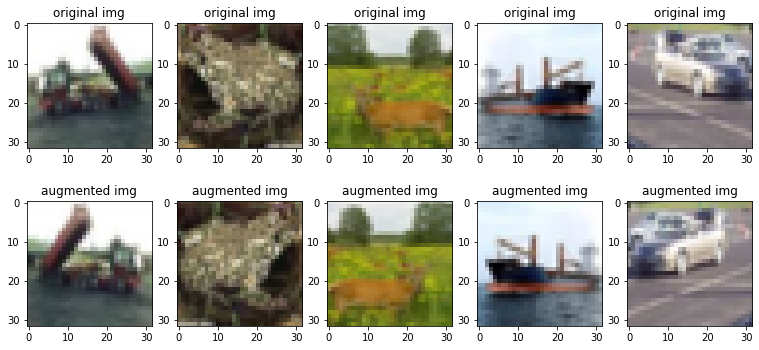

In [27]:
flip = transforms.RandomHorizontalFlip(p=1)
display_augmented_images(flip)

# RandomCrop
모든 **이미지의 사이즈가 일정**한 이미지 데이터셋 *e.g.) CIFAR-10, CIFAR-100, MNIST*에서 주로 사용되는 input 크기 정규화 방법.
```
transforms.RandomCrop(32, padding=4)
```
: CIFAR-10 기준 (32,32)에 4px 씩 상하좌우 padding 후 (32,32) size로 crop

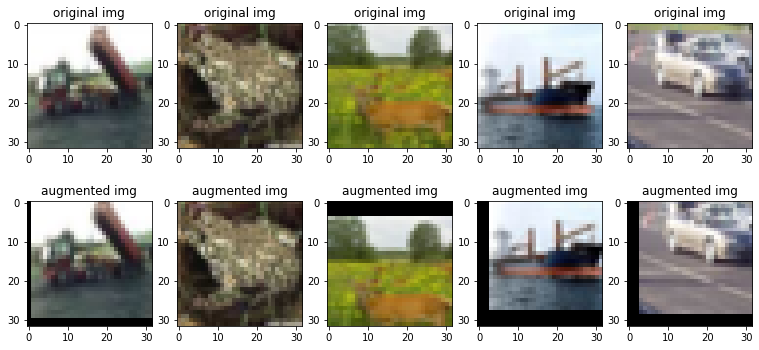

In [28]:
resize_randomcrop = transforms.RandomCrop(32, padding=4)
display_augmented_images(resize_randomcrop)

# Resize, then RandomResizedCrop
주어진 **이미지들의 사이즈(width, height)가 일정하지 않을 때** *e.g.) ImageNet(ILSVRC2012)*에서 주로 사용되는 input 크기 정규화 방법.

```
transforms.Compose([
                    transforms.Resize(size=40),
                    transforms.RandomResizedCrop(size=32),
                    ])
```

## Resize 
: (width, height) 크기의 이미지가 있을 때, 먼저 입력한 40으로 크기 조정. width와 height 중 작은 것을 기준으로 가로와 세로 사이의 비율이 유지되며 크기 조정이 이루어짐.

e.g.) (80, 120) -> (40, 60)

default: bilinear interpolation

## RandomResizedCrop 
: 주어진 scale 값으로 crop 후, 주어진 size로 resize하는 augmentation

e.g.) (300, 500) -> [ (24, 40), (300, 500) ] 범위 사이의 크기로 crop 후, (32, 32) 크기로 resize.

default: scale = (0.08, 1.0)


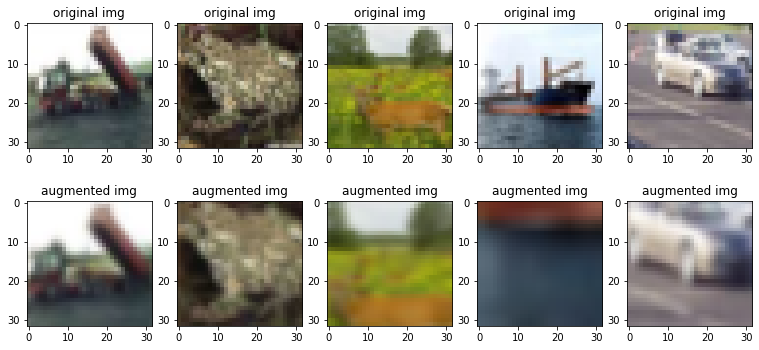

In [29]:
randomresizedcrop = transforms.Compose([
                            transforms.Resize(size=40),
                            transforms.RandomResizedCrop(size=32),
                            ])

display_augmented_images(randomresizedcrop)

# AutoAugment
[ available on torchvision==0.9.1 / stable ver. 0.10.0 ]

AutoAugment: Learning Augmentation Strategies from Data (Cubuk et al., CVPR 2019)

https://arxiv.org/abs/1805.09501

3가지 policy 사용 가능
- transforms.AutoAugmentPolicy.CIFAR10
- transforms.AutoAugmentPolicy.IMAGENET
- transforms.AutoAugmentPolicy.SVHN

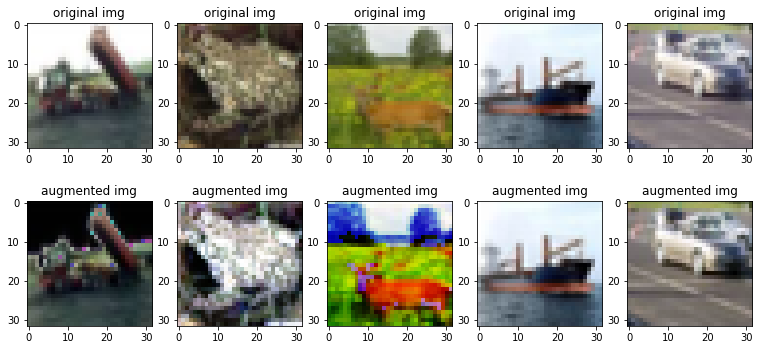

In [30]:
autoaugment = transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10)
display_augmented_images(autoaugment)

# RandAugment

Randaugment: Practical automated data augmentation with a reduced search space(Cubuk et al., CVPR 2020)]

https://arxiv.org/abs/1909.13719

- **n** indicates the number of augmentations to be applied.
- **m** indicates the magnitude of the augmentations being applied.

[ will be available on torchvision==0.12.0 / no stable ver. currently (21.10.19) ]

In [31]:
!pip install git+https://github.com/ildoonet/pytorch-randaugment

  Cloning https://github.com/ildoonet/pytorch-randaugment to /tmp/pip-req-build-1kjyssfz
  Running command git clone -q https://github.com/ildoonet/pytorch-randaugment /tmp/pip-req-build-1kjyssfz


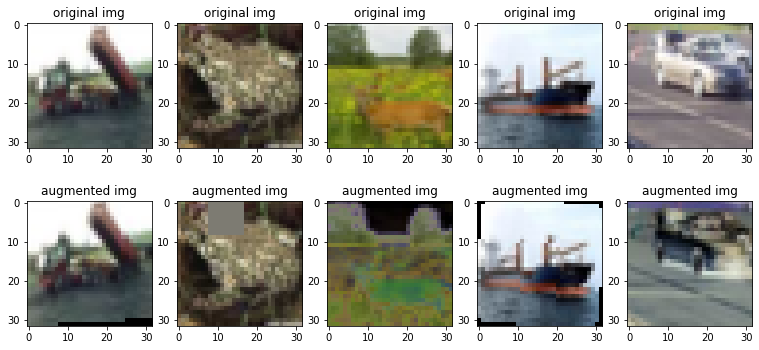

In [32]:
from RandAugment import RandAugment

randaugment = RandAugment(n=1, m=6)
display_augmented_images(randaugment)

In [33]:
%%script false --no-raise-error
# unstable version of torchvision is not installable on Google Colab environment

!pip3 install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu102/torch_nightly.html
!git clone https://github.com/pytorch/vision.git
%cd vision
!python setup.py develop
%cd ..

randaugment = transforms.RandAugment()
display_augmented_images(randaugment)

# Determine Augmentation and Define Dataloader

In [34]:
train_transform = transforms.Compose([
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainset.gen_noise(err_rate = 50, err_method='symmetry') # inject noise

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Noisy labels generated
Files already downloaded and verified


# Convolution Neural Network

In [35]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def get_embedding(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

    def forward(self, x):
        x = self.get_embedding(x)
        x = self.fc3(x)
        return x

net = Net().cuda()

# 손실함수 (Cross Entropy Loss)

In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# 모델 학습

In [37]:
num_class = 10

for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels, noisy_label, idx = data
        inputs, noisy_label = inputs.cuda(), noisy_label.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward, backward, and optimize
        outputs = net(inputs)

        loss = criterion(outputs, noisy_label)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[Epoch %d]%5dth batch loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Epoch 1]  100th batch loss: 2.292
[Epoch 1]  200th batch loss: 2.287
[Epoch 1]  300th batch loss: 2.280
[Epoch 2]  100th batch loss: 2.264
[Epoch 2]  200th batch loss: 2.257
[Epoch 2]  300th batch loss: 2.244
[Epoch 3]  100th batch loss: 2.242
[Epoch 3]  200th batch loss: 2.232
[Epoch 3]  300th batch loss: 2.231
[Epoch 4]  100th batch loss: 2.214


KeyboardInterrupt: ignored

# Accuracy
- #### Train dataset에서의 accuracy
- #### Test dataset에서의 accuracy

In [38]:
def accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        if loader.dataset.train == False: # testloader
            for data in loader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        else: # trainloader with noise.
            for data in loader:
                images, labels, noisy_label, idx = data
                images, noisy_label = images.cuda(), noisy_label.cuda()
                # images, labels = images.cuda(), labels.cuda()

                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += noisy_label.size(0)
                correct += (predicted == noisy_label).sum().item()
    return 100 * correct / total

train_acc = accuracy(trainloader)
test_acc = accuracy(testloader)

print('Accuracy of the network on the 50000 train images: %d %%' % (train_acc))
print('Accuracy of the network on the 10000 test images: %d %%' % (test_acc))

Accuracy of the network on the 50000 train images: 17 %
Accuracy of the network on the 10000 test images: 33 %


학습 초반에는 train accuracy가 test accuracy보다 낮지만,

학습 후반으로 갈수록 train accuracy가 test accuracy를 역전하고, test accuracy는 낮아지며 noisy label에 overfitting 되는 것을 관찰할 수 있습니다.

## Class 별 Accuracy

In [39]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 27 %
Accuracy of   car : 42 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog : 57 %
Accuracy of  frog : 44 %
Accuracy of horse : 44 %
Accuracy of  ship : 75 %
Accuracy of truck :  7 %


###Save Embedding for UMAP###

penultimate layer - classification layer 직전의 layer output을 이용해 각 data의 representation이 어떻게 표현되는지 살펴보겠습니다.

In [40]:
save_embeddings = np.array([]).reshape(0,84)
save_labels = []

with torch.no_grad():
    for i, data in enumerate(trainloader):
                    # ret = ret + (self.noisy_target[index], index)
        images, labels, noisy_label, idx = data
        images = images.cuda()
        embeddings = net.get_embedding(images)
        save_embeddings = np.vstack([save_embeddings, embeddings.cpu().numpy()])
        # print(embeddings.cpu().numpy().shape)
        save_labels = np.append(save_labels, np.array(labels))

In [41]:
# 우리가 학습한 모델이 84차원의 크기로 표현한 representation vectors (trainset-50000개 데이터)
print(save_embeddings.shape)

[[0.15753429 0.22769515 0.         ... 0.47271138 0.08682274 0.2079553 ]
 [0.71775198 0.19038317 0.         ... 0.15934376 0.         0.25618801]
 [0.55397516 0.25387761 0.         ... 0.19394135 0.         0.        ]
 ...
 [0.17534719 0.07131788 0.         ... 0.38684863 0.         0.05399661]
 [0.15903307 0.16817555 0.         ... 0.13925061 0.1113202  0.07686496]
 [0.20350182 0.17873056 0.         ... 0.29719001 0.01318557 0.05038827]]
(50000, 84)


## Now let's visualize the representation learned on the neural network we trained.

In [55]:
!pip install umap-learn[plot]

     |████████████████████████████████| 15.8 MB 634 bytes/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
     |████████████████████████████████| 125 kB 52.8 MB/s 
     |████████████████████████████████| 786 kB 42.7 MB/s 
     |████████████████████████████████| 779 kB 45.5 MB/s 
     |████████████████████████████████| 778 kB 45.0 MB/s 
     |████████████████████████████████| 776 kB 40.7 MB/s 
     |████████████████████████████████| 769 kB 36.2 MB/s 
     |████████████████████████████████| 766 kB 39.6 MB/s 
     |████████████████████████████████| 1.0 MB 39.8 MB/s 
     |████████████████████████████████| 722 kB 48.1 MB/s 
     |████████████████████████████████| 722 kB 35.1 MB/s 
     |████████████████████████████████| 715 kB 49.6 MB/s 
     |████████████████████████████████| 705 kB 48.5 MB/s 
     |████████████████████████████████| 699 kB 46.1 MB/s 
     |████████████████████████████████| 696 kB 46.5 MB/s 
     |████████████████████████████████| 684 kB 45.5 MB/s 
     |███████

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(save_embeddings)

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=save_labels, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the CIFAR10 dataset', fontsize=24);

ModuleNotFoundError: ignored

#### 2차원 공간에 표현한 representation

In [57]:
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(save_embeddings)

import plotly.express as px
fig = px.scatter(
    embedding, x=0, y=1,
    color=save_labels
)
fig.update_traces(marker_size=4)
fig.show()

####3차원 공간에 표현한 representation

기능 설명
- 마우스 드래그 - 시점 전환
- 스크롤 - 확대/축소


In [58]:
# %matplotlib inline
# import numpy as np
# import matplotlib.pyplot as plt
# import umap
import plotly.express as px

reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(save_embeddings)

fig = px.scatter_3d(
    embedding, x=0, y=1, z=2,
    color=save_labels
)
fig.update_traces(marker_size=2)
fig.update_layout(width=1500, height=1500)
fig.show()

In [3]:
# kmeans clustering

!pip install Cython
!pip install -U scikit-learn==1.0

# # kmeans clustering faster with >=0.23 version / default version==0.22

     |████████████████████████████████| 23.1 MB 57.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [43]:
import sklearn
sklearn.__version__

'1.0'

In [44]:
# %%time

from sklearn.cluster import KMeans

num_clusters = 20
num_classes = 10

kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(save_embeddings)

KMeans(n_clusters=20, random_state=0)

In [2]:
save_embeddings_test = np.array([]).reshape(0,84)
save_labels_test = []

with torch.no_grad():
    for i, data in enumerate(testloader):
        images, labels = data
        images = images.cuda()
        embeddings = net.get_embedding(images)
        save_embeddings_test = np.vstack([save_embeddings_test, embeddings.cpu().numpy()])
        save_labels_test = np.append(save_labels_test, np.array(labels))

kmeans_predict = kmeans.predict(save_embeddings_test.reshape(10000,-1))

NameError: ignored

In [46]:
kmeans_predict

array([11,  7,  7, ..., 11,  3,  2], dtype=int32)

In [47]:
representations = np.zeros((num_clusters, num_classes))
for i, k_pred in enumerate(kmeans_predict):
    representations[k_pred][int(save_labels_test[i])] +=1

In [48]:
representations

array([[  4.,   0.,   7.,  13.,   2.,  58.,   1.,   9.,   0.,   0.],
       [141., 218.,  23.,  10.,  19.,   4.,   3.,   7., 170.,  57.],
       [ 11.,  16.,  27.,  54.,  36.,  51.,  48., 184.,   2.,  22.],
       [ 20.,  11.,  34.,  58.,  17.,  80.,  17.,  41.,  22.,  16.],
       [139.,  12.,  29.,   4.,   7.,   3.,   0.,   3.,  46.,  13.],
       [ 18.,  47.,  25.,  34.,  31.,  16.,  26., 149.,  19., 141.],
       [ 33.,  98., 147., 143., 125.,  93., 142.,  90.,  24.,  71.],
       [133.,  93.,   9.,   0.,   7.,   4.,   0.,   5., 272.,  86.],
       [ 25.,  23.,  21.,  24.,   3.,  24.,   4.,  29.,  51.,  44.],
       [ 43.,  14.,  48.,  61.,  34.,  27.,  22.,  36.,  28.,  22.],
       [ 25.,   2.,  38.,  56.,  39.,  57.,  24.,  78.,   2.,   5.],
       [ 24.,  24., 196., 194., 281., 153., 357., 111.,   8.,  32.],
       [ 69., 141.,  16.,  18.,  15.,   9.,   6.,  25., 142., 321.],
       [ 44.,   2.,  27.,  24.,   8.,  16.,   3.,   4.,  10.,   0.],
       [152.,  32.,  21.,   1.,   

In [49]:
representations_prob = np.round(representations/representations.sum(axis=1)[:, np.newaxis], decimals=2)

In [50]:
print(representations_prob)

[[0.04 0.   0.07 0.14 0.02 0.62 0.01 0.1  0.   0.  ]
 [0.22 0.33 0.04 0.02 0.03 0.01 0.   0.01 0.26 0.09]
 [0.02 0.04 0.06 0.12 0.08 0.11 0.11 0.41 0.   0.05]
 [0.06 0.03 0.11 0.18 0.05 0.25 0.05 0.13 0.07 0.05]
 [0.54 0.05 0.11 0.02 0.03 0.01 0.   0.01 0.18 0.05]
 [0.04 0.09 0.05 0.07 0.06 0.03 0.05 0.29 0.04 0.28]
 [0.03 0.1  0.15 0.15 0.13 0.1  0.15 0.09 0.02 0.07]
 [0.22 0.15 0.01 0.   0.01 0.01 0.   0.01 0.45 0.14]
 [0.1  0.09 0.08 0.1  0.01 0.1  0.02 0.12 0.21 0.18]
 [0.13 0.04 0.14 0.18 0.1  0.08 0.07 0.11 0.08 0.07]
 [0.08 0.01 0.12 0.17 0.12 0.17 0.07 0.24 0.01 0.02]
 [0.02 0.02 0.14 0.14 0.2  0.11 0.26 0.08 0.01 0.02]
 [0.09 0.19 0.02 0.02 0.02 0.01 0.01 0.03 0.19 0.42]
 [0.32 0.01 0.2  0.17 0.06 0.12 0.02 0.03 0.07 0.  ]
 [0.52 0.11 0.07 0.   0.01 0.   0.   0.   0.24 0.04]
 [0.09 0.32 0.06 0.07 0.05 0.03 0.04 0.06 0.1  0.18]
 [0.15 0.11 0.11 0.12 0.11 0.06 0.04 0.02 0.2  0.07]
 [0.01 0.01 0.06 0.24 0.05 0.48 0.05 0.07 0.03 0.  ]
 [0.   0.   0.17 0.12 0.16 0.21 0.15 0.16 0.  